In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings
import xml.etree.ElementTree as ET
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2


warnings.filterwarnings("ignore")
hosts_df = pd.read_csv('olympic_hosts.csv')
medals_df = pd.read_csv('olympic_medals.csv')

In [46]:
# Renommage de la colonne 'slug_game' pour avoir une cohésion
medals_df = medals_df.rename({'slug_game': 'game_slug'}, axis=1)
medals_df.columns

Index(['Unnamed: 0', 'discipline_title', 'game_slug', 'event_title',
       'event_gender', 'medal_type', 'participant_type', 'participant_title',
       'athlete_url', 'athlete_full_name', 'country_name', 'country_code',
       'country_3_letter_code'],
      dtype='object')

In [47]:
# Supprimer les colonnes non nécessaires
medals_df.drop(['Unnamed: 0', 'participant_title', 'athlete_url'], axis=1, inplace=True)
print(medals_df.head())

  discipline_title     game_slug    event_title event_gender medal_type  \
0          Curling  beijing-2022  Mixed Doubles        Mixed       GOLD   
1          Curling  beijing-2022  Mixed Doubles        Mixed       GOLD   
2          Curling  beijing-2022  Mixed Doubles        Mixed     SILVER   
3          Curling  beijing-2022  Mixed Doubles        Mixed     SILVER   
4          Curling  beijing-2022  Mixed Doubles        Mixed     BRONZE   

  participant_type     athlete_full_name country_name country_code  \
0         GameTeam  Stefania CONSTANTINI        Italy           IT   
1         GameTeam          Amos MOSANER        Italy           IT   
2         GameTeam      Kristin SKASLIEN       Norway           NO   
3         GameTeam    Magnus NEDREGOTTEN       Norway           NO   
4         GameTeam         Almida DE VAL       Sweden           SE   

  country_3_letter_code  
0                   ITA  
1                   ITA  
2                   NOR  
3                   NOR 

In [48]:
# Extraire les données qui concerne la France
france_medals = medals_df[medals_df['country_name'] == 'France']
print(france_medals.head())

     discipline_title     game_slug              event_title event_gender  \
26   Freestyle Skiing  beijing-2022  Women's Freeski Big Air        Women   
88          Snowboard  beijing-2022  Women's Snowboard Cross        Women   
139    Figure skating  beijing-2022                Ice Dance        Mixed   
140    Figure skating  beijing-2022                Ice Dance        Mixed   
172          Biathlon  beijing-2022     Men's 12.5km Pursuit          Men   

    medal_type participant_type       athlete_full_name country_name  \
26      SILVER          Athlete             Tess LEDEUX       France   
88      SILVER          Athlete         Chloe TRESPEUCH       France   
139       GOLD         GameTeam     Gabriella PAPADAKIS       France   
140       GOLD         GameTeam       Guillaume CIZERON       France   
172       GOLD          Athlete  Quentin FILLON MAILLET       France   

    country_code country_3_letter_code  
26            FR                   FRA  
88            FR      

In [49]:
#Regroupement des données par la colonne "game_slug" et comptage du nombre de médailles
medals_count = france_medals.groupby(['game_slug'])['medal_type'].count().reset_index()
print(medals_count.head())

          game_slug  medal_type
0  albertville-1992          10
1    amsterdam-1928          21
2      antwerp-1920          45
3       athens-1896          11
4       athens-2004          36


In [50]:
# Renommage des deux colonnes
medals_count.columns = ['game_slug', 'medal_count']
print(medals_count.head())

          game_slug  medal_count
0  albertville-1992           10
1    amsterdam-1928           21
2      antwerp-1920           45
3       athens-1896           11
4       athens-2004           36


In [51]:
# Fusion avec des données de "hosts_df" et "medals_count" 
merged_df = hosts_df.merge(medals_count, on='game_slug', how='left')
# Remplissage des valeurs manquantes avec 0
merged_df['medal_count'].fillna(0, inplace=True)  
print(merged_df.head())

   index         game_slug         game_end_date       game_start_date  \
0      0      beijing-2022  2022-02-20T12:00:00Z  2022-02-04T15:00:00Z   
1      1        tokyo-2020  2021-08-08T14:00:00Z  2021-07-23T11:00:00Z   
2      2  pyeongchang-2018  2018-02-25T08:00:00Z  2018-02-08T23:00:00Z   
3      3          rio-2016  2016-08-21T21:00:00Z  2016-08-05T12:00:00Z   
4      4        sochi-2014  2014-02-23T16:00:00Z  2014-02-07T04:00:00Z   

        game_location         game_name game_season  game_year  medal_count  
0               China      Beijing 2022      Winter       2022         15.0  
1               Japan        Tokyo 2020      Summer       2020         37.0  
2   Republic of Korea  PyeongChang 2018      Winter       2018         17.0  
3              Brazil          Rio 2016      Summer       2016         45.0  
4  Russian Federation        Sochi 2014      Winter       2014         15.0  


In [52]:
# Création de la colonne 'is_host'. Si game_location = 'France' ALORS 1 SINON 0.
merged_df['is_host'] = merged_df['game_location'].apply(lambda x: 1 if 'France' in x else 0)

# Création de la colonne "year" avec les données de la colonne "game_year"
merged_df['year'] = merged_df['game_year']

# Création de la colonne 'season'. Si game_season = 'Summer' ALORS 1 SINON 0.
merged_df['season'] = merged_df['game_season'].apply(lambda x: 1 if x == 'Summer' else 0)

# Convertir les colonnes en type float32
merged_df['year'] = merged_df['year'].astype('float32')
merged_df['season'] = merged_df['season'].astype('float32')
merged_df['is_host'] = merged_df['is_host'].astype('float32')
merged_df['medal_count'] = merged_df['medal_count'].astype('float32')

# Afficher les premières lignes du DataFrame pour vérification
print("Premières lignes du DataFrame:")
print(merged_df.head())

# Afficher les types de données
print("\nTypes de données:")
print(merged_df.dtypes)

# Sélection des caractéristiques
X = merged_df[['year', 'season', 'is_host']]
y = merged_df['medal_count']

# Normaliser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Afficher les dimensions des ensembles d'entraînement et de test
print("\nDimensions des ensembles:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

# Construire le modèle de deep learning
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1))  # Sortie avec une seule unité pour la régression

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Afficher le résumé du modèle
print("\nRésumé du modèle:")
model.summary()

# Entraîner le modèle
print("\nEntraînement du modèle...")
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.2)

# Évaluer le modèle
print("\nÉvaluation du modèle sur l'ensemble de test:")
loss, mae = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, MAE: {mae}')

# Préparer les données pour la prédiction de 2024
# On suppose que la France est l'hôte en 2024 et que les jeux sont d'été
data_2024 = pd.DataFrame({
    'year': [2024.0],
    'season': [1.0],  # 1 pour l'été
    'is_host': [1.0]  # 1 car la France est l'hôte
})

# Normaliser les caractéristiques de 2024
data_2024_scaled = scaler.transform(data_2024)

# Faire la prédiction pour 2024
pred_2024 = model.predict(data_2024_scaled)
print(f'\nPrédiction du nombre de médailles pour la France en 2024: {pred_2024[0][0]}')



Premières lignes du DataFrame:
   index         game_slug         game_end_date       game_start_date  \
0      0      beijing-2022  2022-02-20T12:00:00Z  2022-02-04T15:00:00Z   
1      1        tokyo-2020  2021-08-08T14:00:00Z  2021-07-23T11:00:00Z   
2      2  pyeongchang-2018  2018-02-25T08:00:00Z  2018-02-08T23:00:00Z   
3      3          rio-2016  2016-08-21T21:00:00Z  2016-08-05T12:00:00Z   
4      4        sochi-2014  2014-02-23T16:00:00Z  2014-02-07T04:00:00Z   

        game_location         game_name game_season  game_year  medal_count  \
0               China      Beijing 2022      Winter       2022         15.0   
1               Japan        Tokyo 2020      Summer       2020         37.0   
2   Republic of Korea  PyeongChang 2018      Winter       2018         17.0   
3              Brazil          Rio 2016      Summer       2016         45.0   
4  Russian Federation        Sochi 2014      Winter       2014         15.0   

   is_host    year  season  
0      0.0  2022.0  

4/4 [==============================] - 0s 16ms/step - loss: 81.4572 - mae: 5.9248 - val_loss: 660.6233 - val_mae: 12.7706
Epoch 41/100
4/4 [==============================] - 0s 17ms/step - loss: 51.4178 - mae: 5.0141 - val_loss: 661.3131 - val_mae: 12.6574
Epoch 42/100
4/4 [==============================] - 0s 16ms/step - loss: 88.2541 - mae: 6.8584 - val_loss: 655.4384 - val_mae: 12.5530
Epoch 43/100
4/4 [==============================] - 0s 17ms/step - loss: 73.6552 - mae: 6.2708 - val_loss: 636.1844 - val_mae: 12.4261
Epoch 44/100
4/4 [==============================] - 0s 16ms/step - loss: 59.9146 - mae: 5.4256 - val_loss: 623.2047 - val_mae: 12.3165
Epoch 45/100
4/4 [==============================] - 0s 21ms/step - loss: 48.3389 - mae: 5.4730 - val_loss: 609.6520 - val_mae: 12.2021
Epoch 46/100
4/4 [==============================] - 0s 17ms/step - loss: 58.2545 - mae: 5.2461 - val_loss: 599.5552 - val_mae: 12.1083
Epoch 47/100
4/4 [==============================] - 0s 17ms/step - l


Évaluation du modèle sur l'ensemble de test:
1/1 [==============================] - 0s 35ms/step - loss: 138.7440 - mae: 8.8552
Loss: 138.74400329589844, MAE: 8.855242729187012
1/1 [==============================] - 0s 90ms/step

Prédiction du nombre de médailles pour la France en 2024: 41.689083099365234



Historique des médailles en JSON:
[{"year":1896.0,"medal_count":11.0},{"year":1900.0,"medal_count":103.0},{"year":1904.0,"medal_count":1.0},{"year":1908.0,"medal_count":20.0},{"year":1912.0,"medal_count":17.0},{"year":1920.0,"medal_count":45.0},{"year":1924.0,"medal_count":4.0},{"year":1924.0,"medal_count":43.0},{"year":1928.0,"medal_count":2.0},{"year":1928.0,"medal_count":21.0},{"year":1932.0,"medal_count":2.0},{"year":1932.0,"medal_count":20.0},{"year":1936.0,"medal_count":19.0},{"year":1936.0,"medal_count":1.0},{"year":1948.0,"medal_count":32.0},{"year":1948.0,"medal_count":5.0},{"year":1952.0,"medal_count":1.0},{"year":1952.0,"medal_count":17.0},{"year":1956.0,"medal_count":0.0},{"year":1956.0,"medal_count":15.0},{"year":1960.0,"medal_count":3.0},{"year":1960.0,"medal_count":5.0},{"year":1964.0,"medal_count":7.0},{"year":1964.0,"medal_count":16.0},{"year":1968.0,"medal_count":9.0},{"year":1968.0,"medal_count":16.0},{"year":1972.0,"medal_count":3.0},{"year":1972.0,"medal_count":15

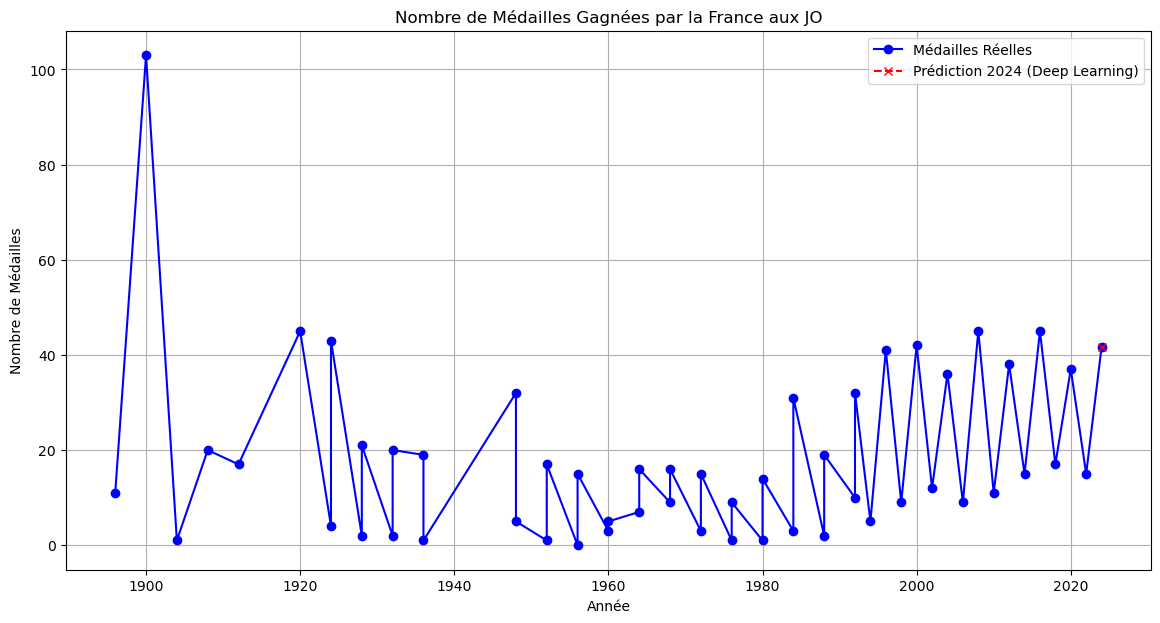

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np

# Extraire les années et les comptes de médailles
results = merged_df[['year', 'medal_count']].drop_duplicates().sort_values(by='year').copy()
results = pd.concat([results, pd.DataFrame({'year': [2024], 'medal_count': [None]})], ignore_index=True)

# Conversion en JSON
historical_medals_json = results.to_json(orient='records')
print("\nHistorique des médailles en JSON:")
print(historical_medals_json)

# Sauvegarder le JSON dans un fichier
with open('historical_medals.json', 'w') as file:
    json.dump(json.loads(historical_medals_json), file, indent=4)

# Normalisation des données de 2024 pour la prédiction
data_2024_scaled = scaler.transform([[2024.0, 1.0, 1.0]])
pred_2024 = model.predict(data_2024_scaled)[0][0]

# Ajouter la prédiction pour 2024
results.loc[results['year'] == 2024, 'medal_count'] = pred_2024

# Visualisation des résultats et prédictions avec des couleurs distinctes
plt.figure(figsize=(14, 7))
plt.plot(results['year'], results['medal_count'], marker='o', label='Médailles Réelles', color='blue')
plt.plot(results[results['year'] == 2024]['year'], results[results['year'] == 2024]['medal_count'], 
         marker='x', linestyle='--', label='Prédiction 2024 (Deep Learning)', color='red')

plt.xlabel('Année')
plt.ylabel('Nombre de Médailles')
plt.title('Nombre de Médailles Gagnées par la France aux JO')
plt.legend()
plt.grid(True)
plt.show()
